# Importing Required Packages

In [1]:
import pandas as pd
import numpy as np

from arch import arch_model

from math import sqrt
from sklearn.metrics import mean_squared_error

import statsmodels.graphics.tsaplots as sgt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings("ignore")

# Reading the datasets

Steps:
- Read the respective .csv file.
- Drop all redundant rows and columns
- Convert **Date** field from string to datetime format.
- Set **Date** as the index of the dataframe.

### Complete Dataset

In [2]:
data = pd.read_csv('web_scrapped_data.csv')
data = data.drop(['Unnamed: 0'], axis=1)
data = data.drop([0], axis=0)
data.Date = pd.to_datetime(data.Date)
data = data.set_index('Date')
data = data.drop(['index'], axis=1)

### Train Dataset

In [3]:
df = pd.read_csv('train.csv')
df = df.drop(['Unnamed: 0'], axis=1)
df = df.drop([0], axis=0)
df.Date = pd.to_datetime(df.Date)
df = df.set_index('Date')
df = df.drop(['index'], axis=1)

### Test Dataset

In [4]:
df_test = pd.read_csv('test.csv')
df_test = df_test.drop(['Unnamed: 0'], axis=1)
df_test = df_test.drop([0], axis=0)
df_test.Date = pd.to_datetime(df_test.Date)
df_test = df_test.set_index('Date')
df_test = df_test.drop(['index'], axis=1)

Here, the start and end dates between which predictions need to be made are initialized. 

In [5]:
start_date = '2014-07-15'
end_date = '2019-08-30'

# Few Relevant Graphs

- **ROW 1**: SPX Returns and SPX Volatility
- **ROW 2**: PACF plots for SPX Returns and Volatility

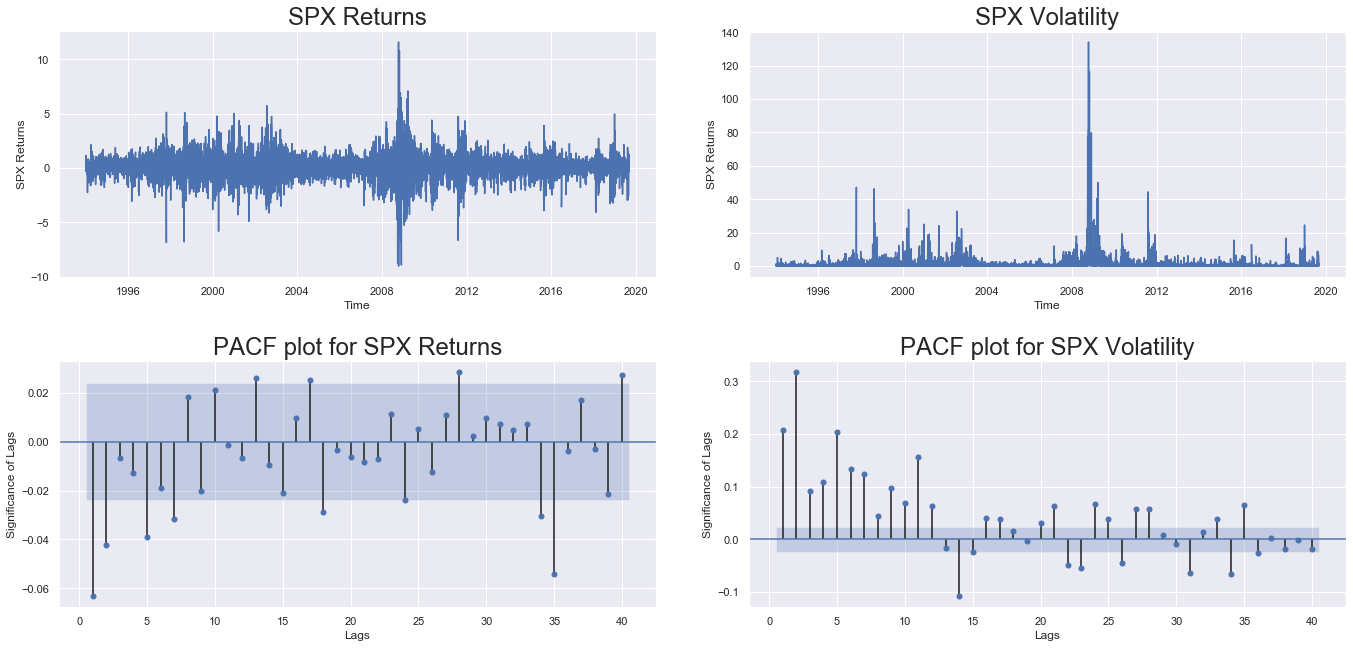

In [6]:
plt.rcParams['figure.figsize'] = 20, 10
fig, ax = plt.subplots(2, 2)
fig.tight_layout(pad=5.0)

ax[0, 0].plot(data.spx_ret[1:])
ax[0, 0].set_title('SPX Returns', size=24)
ax[0, 0].set_xlabel('Time')
ax[0, 0].set_ylabel('SPX Returns')

ax[0, 1].plot(data.spx_vol[1:])
ax[0, 1].set_title('SPX Volatility', size=24)
ax[0, 1].set_xlabel('Time')
ax[0, 1].set_ylabel('SPX Returns')

sgt.plot_pacf(data.spx_ret[1:], zero = False, lags = 40, ax=ax[1, 0])
ax[1, 0].set_title('PACF plot for SPX Returns', size=24)
ax[1, 0].set_xlabel('Lags')
ax[1, 0].set_ylabel('Significance of Lags')

sgt.plot_pacf(data.spx_vol[1:], zero = False, lags = 40, ax=ax[1, 1])
ax[1, 1].set_title('PACF plot for SPX Volatility', size=24)
ax[1, 1].set_xlabel('Lags')
ax[1, 1].set_ylabel('Significance of Lags')

plt.show()

# Simple ARCH Model

In the code sections below, a simple **ARCH(1)** model is implemented.

Steps:
- Build the simple **ARCH(1)** using the dataset **data**.
- Specify **start_date** as the **last_obs** in the **fit()** method.
- Use the model to predict the values from the **start_date** to the **end_date**.
- Plot the model's predictions against the actual values from the test dataset **df_test**.
- Find statistical measures for the model's accuracy.

In [7]:
spx_arch_1_model = arch_model(data.spx_ret[1:], mean="Constant", vol="ARCH", p=1)
spx_arch_1_results = spx_arch_1_model.fit(update_freq = 5, last_obs=start_date)
spx_arch_1_results.summary()

Iteration:      5,   Func. Count:     34,   Neg. LLF: 8242.524340483047
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 8242.524322873292
            Iterations: 6
            Function evaluations: 39
            Gradient evaluations: 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                spx_ret   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                       ARCH   Log-Likelihood:               -8242.52
Distribution:                  Normal   AIC:                           16491.0
Method:            Maximum Likelihood   BIC:                           16510.8
                                        No. Observations:                 5352
Date:                Wed, Apr 01 2020   Df Residuals:                     5349
Time:                        23:03:03   Df Model:                            3
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0515  1.724e-02      2.988  2.806e-03 [1.772e-02,8.529e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          1.0191  5.315e-02     19.175  5.937e-82 [  0.915,  1.123]
alpha[1]       0.2865  4.898e-02      5.850  4.912e-09 [  0.191,  0.383]
========================================================================

Covariance estimator: robust
"""

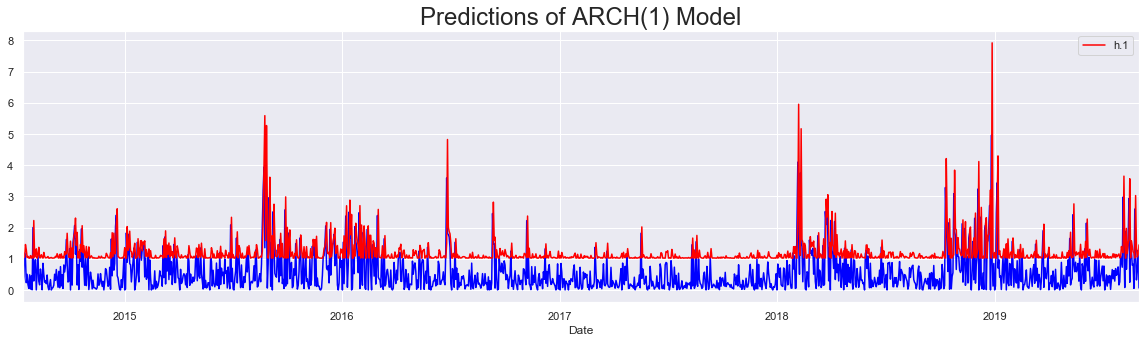

In [8]:
spx_arch_1_pred = spx_arch_1_results.forecast(horizon=1, align='target')

spx_arch_1_pred.residual_variance[start_date:end_date].plot(figsize = (20,5), color = "red", zorder = 2)
df_test.spx_ret[start_date:end_date].abs().plot(color = "blue", zorder = 1)
plt.title("Predictions of ARCH(1) Model", size=24)
plt.show()

In [9]:
arch_1_mse = mean_squared_error(df_test.spx_ret[start_date:end_date].abs().values, spx_arch_1_pred.residual_variance[start_date:end_date].values)
arch_1_rmse = sqrt(arch_1_mse)

print("Root Mean Squared Error: "+str(arch_1_rmse))

Root Mean Squared Error: 0.9503556305757089


# Higher Order ARCH(Q) model.

In the code sections below, many higher order **ARCH(Q)** model are implemented. The steps to implement each one are enumerated below.

Steps:
- Build the higher order **ARCH(Q)** using the dataset **data**.
- Specify **start_date** as the **last_obs** in the **fit()** method.
- Use the model to predict the values from the **start_date** to the **end_date**.
- Plot the model's predictions against the actual values from the test dataset **df_test**.
- Find statistical measures for the model's accuracy.

The model that provides all significant coefficiencts in the **Variance/Volatility** equation of the ARCH model along with the highest **Log Likelihood Value** is **ARCH(11)**. Instead of showing the statistics and predictions for all the models till ARCH(11), only the final model is displayed.

In [10]:
spx_arch_11_model = arch_model(data.spx_ret[1:], mean="Constant", vol="ARCH", p=11)
spx_arch_11_results = spx_arch_11_model.fit(update_freq = 5, last_obs=start_date)
spx_arch_11_results.summary()

Iteration:      5,   Func. Count:     85,   Neg. LLF: 7362.673779827718
Iteration:     10,   Func. Count:    169,   Neg. LLF: 7355.583425657596
Iteration:     15,   Func. Count:    253,   Neg. LLF: 7352.641485438737
Iteration:     20,   Func. Count:    335,   Neg. LLF: 7351.811019874378
Iteration:     25,   Func. Count:    413,   Neg. LLF: 7351.694682882797
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7351.694678856625
            Iterations: 26
            Function evaluations: 428
            Gradient evaluations: 26


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                spx_ret   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                       ARCH   Log-Likelihood:               -7351.69
Distribution:                  Normal   AIC:                           14729.4
Method:            Maximum Likelihood   BIC:                           14815.0
                                        No. Observations:                 5352
Date:                Wed, Apr 01 2020   Df Residuals:                     5339
Time:                        23:03:03   Df Model:                           13
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0614  1.152e-02      5.327  9.982e-08 [3.879e-02,8.395e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.1970  2.238e-02      8.802  1.350e-18     [  0.153,  0.241]
alpha[1]       0.0293  1.433e-02      2.045  4.089e-02 [1.214e-03,5.739e-02]
alpha[2]       0.1290  2.552e-02      5.055  4.301e-07   [7.899e-02,  0.179]
alpha[3]       0.0717  1.674e-02      4.282  1.853e-05   [3.888e-02,  0.105]
alpha[4]       0.0950  2.190e-02      4.337  1.444e-05   [5.207e-02,  0.138]
alpha[5]       0.0890  1.870e-02      4.758  1.957e-06   [5.233e-02,  0.126]
alpha[6]       0.0663  1.630e-02      4.066  4.791e-05 [3.433e-02,9.824e-02]
alpha[7]       0.1187  2.509e-02      4.732  2.226e-06   [6.954e-02,  0.168]
alpha[8]       0.0568  2.037e-02      2.787  5.315e-03 [1.685e-02,9.668e-02]
alpha[9]       0.0763  2.087e-02      3.657  2.547e-04   [3.543e-02,  0.117]
alpha[10]      0.0935  2.129e-02      4.395  1.110e-05   [5.182e-02,  0.135]
alpha[11]      0.0434  1.703e-02      2.549  1.080e-02 [1.003e-02,7.679e-02]
============================================================================

Covariance estimator: robust
"""

In [11]:
spx_arch_14_model = arch_model(data.spx_ret[1:], mean="Constant", vol="ARCH", p=14)
spx_arch_14_results = spx_arch_14_model.fit(update_freq = 5, last_obs=start_date)
spx_arch_14_results.summary()

Iteration:      5,   Func. Count:     99,   Neg. LLF: 7351.125169725159
Iteration:     10,   Func. Count:    200,   Neg. LLF: 7344.531049897045
Iteration:     15,   Func. Count:    300,   Neg. LLF: 7342.380557919566
Iteration:     20,   Func. Count:    399,   Neg. LLF: 7341.8711320324055
Iteration:     25,   Func. Count:    498,   Neg. LLF: 7341.777583705314
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7341.7666204695915
            Iterations: 28
            Function evaluations: 553
            Gradient evaluations: 28


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                spx_ret   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                       ARCH   Log-Likelihood:               -7341.77
Distribution:                  Normal   AIC:                           14715.5
Method:            Maximum Likelihood   BIC:                           14820.9
                                        No. Observations:                 5352
Date:                Wed, Apr 01 2020   Df Residuals:                     5336
Time:                        23:03:04   Df Model:                           16
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0608  1.167e-02      5.208  1.904e-07 [3.790e-02,8.363e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.1809  2.297e-02      7.875  3.411e-15      [  0.136,  0.226]
alpha[1]       0.0299  1.406e-02      2.127  3.346e-02  [2.343e-03,5.748e-02]
alpha[2]       0.1246  2.574e-02      4.841  1.289e-06    [7.418e-02,  0.175]
alpha[3]       0.0682  1.659e-02      4.112  3.924e-05    [3.570e-02,  0.101]
alpha[4]       0.0847  2.091e-02      4.048  5.155e-05    [4.368e-02,  0.126]
alpha[5]       0.0766  1.893e-02      4.048  5.157e-05    [3.954e-02,  0.114]
alpha[6]       0.0583  1.630e-02      3.574  3.516e-04  [2.631e-02,9.022e-02]
alpha[7]       0.1028  2.447e-02      4.203  2.630e-05    [5.489e-02,  0.151]
alpha[8]       0.0472  2.139e-02      2.209  2.720e-02  [5.319e-03,8.915e-02]
alpha[9]       0.0700  2.039e-02      3.432  6.001e-04    [3.001e-02,  0.110]
alpha[10]      0.0841  2.087e-02      4.029  5.592e-05    [4.319e-02,  0.125]
alpha[11]      0.0361  1.658e-02      2.177  2.946e-02  [3.603e-03,6.860e-02]
alpha[12]      0.0284  1.769e-02      1.606      0.108 [-6.265e-03,6.309e-02]
alpha[13]      0.0389  1.682e-02      2.314  2.066e-02  [5.957e-03,7.188e-02]
alpha[14]      0.0278  1.563e-02      1.776  7.574e-02 [-2.876e-03,5.838e-02]
=============================================================================

Covariance estimator: robust
"""

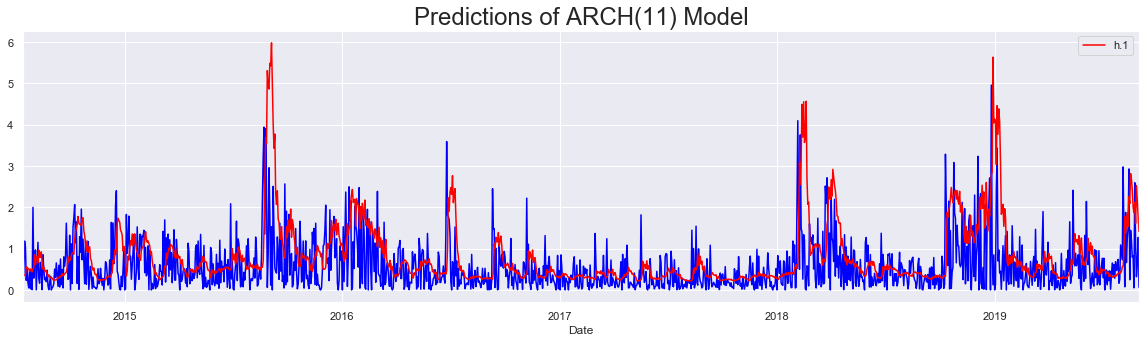

In [12]:
spx_arch_11_pred = spx_arch_11_results.forecast(horizon=1, align='target')

spx_arch_11_pred.residual_variance[start_date:end_date].plot(figsize = (20,5), color = "red", zorder = 2)
df_test.spx_ret[start_date:end_date].abs().plot(color = "blue", zorder = 1)
plt.title("Predictions of ARCH(11) Model", size=24)
plt.show()

In [13]:
arch_11_mse = mean_squared_error(df_test.spx_ret[start_date:end_date].abs().values, spx_arch_11_pred.residual_variance[start_date:end_date].values)
arch_11_rmse = sqrt(arch_11_mse)

print("Root Mean Squared Error: "+str(arch_11_rmse))

Root Mean Squared Error: 0.84453227640572


# Simple GARCH Model

In the code sections below, a simple **GARCH(P, Q)** model is implemented.

Steps:
- Build the simple **GARCH(1, 1)** using the dataset **data**.
- Specify **start_date** as the **last_obs** in the **fit()** method.
- Use the model to predict the values from the **start_date** to the **end_date**.
- Plot the model's predictions against the actual values from the test dataset **df_test**.
- Find statistical measures for the model's accuracy.

It is mathematically proven that no higher order model out-performs the GARCH(1, 1) when it comes to forecasting the volatility of market returns. Thus, no other GARCH variation is implemented. 

In [14]:
spx_garch_model = arch_model(data.spx_ret[1:], mean="Constant", vol="GARCH", p=1, q=1)
spx_garch_results = spx_garch_model.fit(last_obs=start_date, update_freq=5)
spx_garch_results.summary()

Iteration:      5,   Func. Count:     39,   Neg. LLF: 7346.970916886512
Iteration:     10,   Func. Count:     74,   Neg. LLF: 7342.2677967205245
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7342.254881419503
            Iterations: 12
            Function evaluations: 86
            Gradient evaluations: 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                spx_ret   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -7342.25
Distribution:                  Normal   AIC:                           14692.5
Method:            Maximum Likelihood   BIC:                           14718.9
                                        No. Observations:                 5352
Date:                Wed, Apr 01 2020   Df Residuals:                     5348
Time:                        23:03:05   Df Model:                            4
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0625  1.117e-02      5.595  2.210e-08 [4.060e-02,8.440e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0110  3.295e-03      3.334  8.553e-04 [4.529e-03,1.745e-02]
alpha[1]       0.0786  1.017e-02      7.723  1.136e-14 [5.863e-02,9.850e-02]
beta[1]        0.9136  1.062e-02     85.984      0.000     [  0.893,  0.934]
============================================================================

Covariance estimator: robust
"""

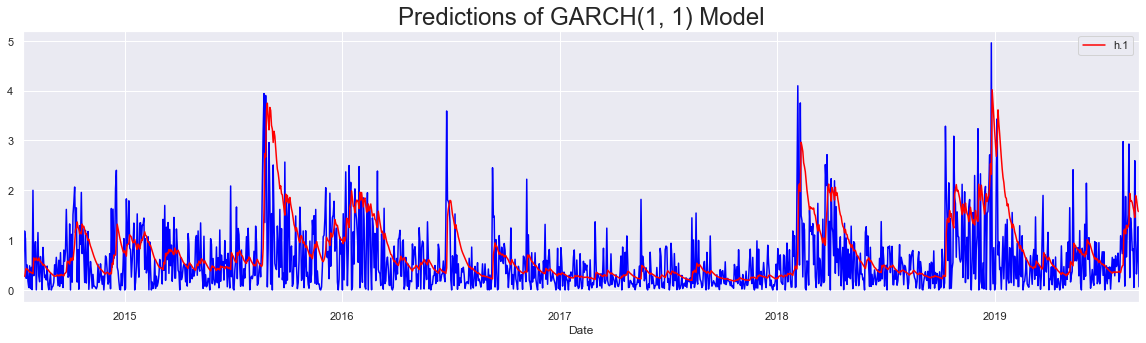

In [15]:
spx_garch_pred = spx_garch_results.forecast(horizon=1, align='target')

spx_garch_pred.residual_variance[start_date:end_date].plot(figsize = (20,5), color = "red", zorder = 2)
df_test.spx_ret[start_date:end_date].abs().plot(color = "blue", zorder = 1)
plt.title("Predictions of GARCH(1, 1) Model", size=24)
plt.show()

In [16]:
garch_mse = mean_squared_error(df_test.spx_ret[start_date:end_date].abs().values, spx_garch_pred.residual_variance[start_date:end_date].values)
garch_rmse = sqrt(garch_mse)

print("Root Mean Squared Error: "+str(garch_rmse))

Root Mean Squared Error: 0.732698198961551
